***
# Specwizard
***

## Description
***

In this notebook we will show an example of the tools an utilities of specwizard. The notebook will go throught different parts:

* Import the necesary modules and functions
* Read necesary data: <br>
  * Read parameter file <br>
  * Read Line of sight file (LOS) <br>
  * Read Simulation data <br>
  * Convertion Factors <br>
  * Read Ionization tables <br>
* Conversion from Simulation to Physical Units
* Project the data to the pixel size


## Loading all the necesary modules
***

In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import physical_data as const
import reading_data_for_los as RD
import read_ionizationtables as RIT
from read_params_yaml import read_params_yaml
from projectdataf import project_data
from conversion_to_physical import conversion_to_physical as C2P

This is saying the use snapshot file is True


## Reading the data
***

First we will use the function **read_params_yaml**

In [9]:
parameters = read_params_yaml('test.yml')

 As it name indicates, this function will read the yaml parameter file, which contains all the configurable options for specwizard. The input of the function is the directory to the '*.yml' parameter file. And will return a class where you can access all the parameter values given by the user. For Example: 

In [15]:
print("Simulation data directory: %s" %parameters.datadir)
print("Would we use the H1 ion?: %s"  %parameters.doH1)
print("Would we use the He2 ion?: %s" %parameters.doHe2)

Simulation data directory: /cosma6/data/dp004/dc-aram1/VariableIMF/patchrea/12dat/snapshot_028_z000p000/
Would we use the H1 ion?: True
Would we use the He2 ion?: False


This class will be used for several functions in the code 
***

Next we will load the simulation data. In this case we will read from a file that contains the information from individual lines of sight (LOS). As we can see in the parameter file 'test.yml'

In [17]:
parameters.use_los_file

True

***
Important parameters of simulations( such as boxsize or number of gas particles) are usually stored in a  **heather** in the file. For accessing them, we will use the function **read_header** from the module **reading_data_for_los** that we imported as **RD**. As input will take the parameter class.


In [ ]:
simdata = RD.read_header(parameters)

As an output we will have an object that contains the header informatio

For loading the data we will use the function **reading_data_for_los** from the module **reading_data_for_los** that we imported as RD. As input it takes the class parameters, and when we have the option *parameters.use_los_file= True*  we also have to provide the Line of sight number (LOS_Number), that we will read from the file (i,e 0->First line of sight in the file)

In [18]:
LOS_number = 0
los = RD.read_particle_data_from_los(parameters,LOS_number)  

LOS0/PartType0/Positions


As an output we will haven a object called los, where we can retreive all the needed information from the LOS. For example, we can use some attributes to make some important plots:

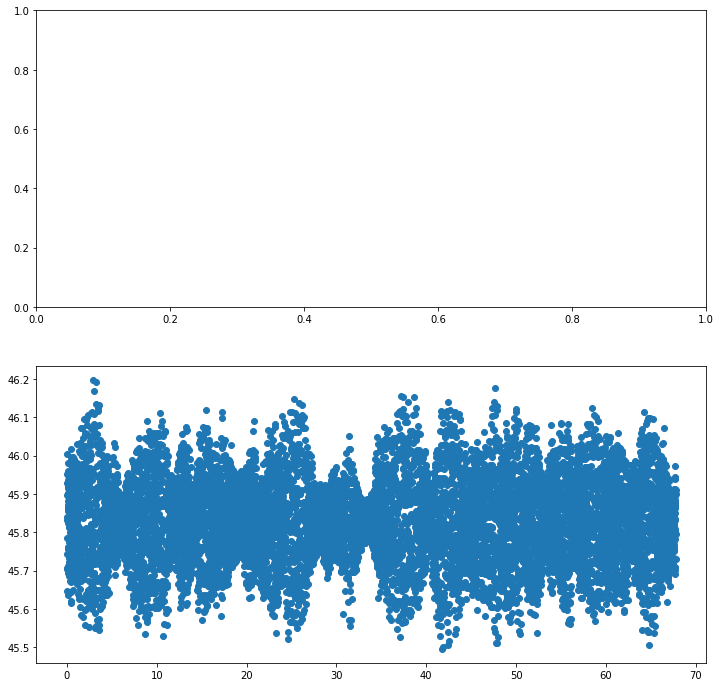

In [24]:
fig, axs = plt.subplots(2,figsize=(12,12))
axs[0] = plt.scatter(los.Position[:,2],los.Position[:,1])


In [2]:

#Load class that contianes the particle information i,e position, velocities etc.
      



#Conversion factors 
convert = RD.units_and_factors_for_los(parameters)


LOS0/PartType0/Positions


In [3]:
#Add to sim data some useful quantities 
acurrent = simdata.ExpansionFactor
zcurrent = simdata.Redshift

simdata.CurrentHubbleCt = 100. * simdata.HubbleParam *  np.sqrt(1. + simdata.Omega0*(1./acurrent-1.) + simdata.OmegaLambda* (acurrent**2-1.)) /acurrent
simdata.boxkms = simdata.BoxSize / simdata.HubbleParam * acurrent * simdata.CurrentHubbleCt

simdata.vpixsizekms = 1
simdata.nveloc = int(simdata.boxkms / simdata.vpixsizekms) + 1

In [4]:
#Convert to physical
loss = C2P(loss,simdata,convert,const)

In [5]:
#load ionization table parameters
ionpar = RIT.read_iontables(parameters)

h1 Ionization table loaded


In [6]:
loss,tf = project_data(loss,simdata,parameters,ionpar)

It took 7.418313 seconds


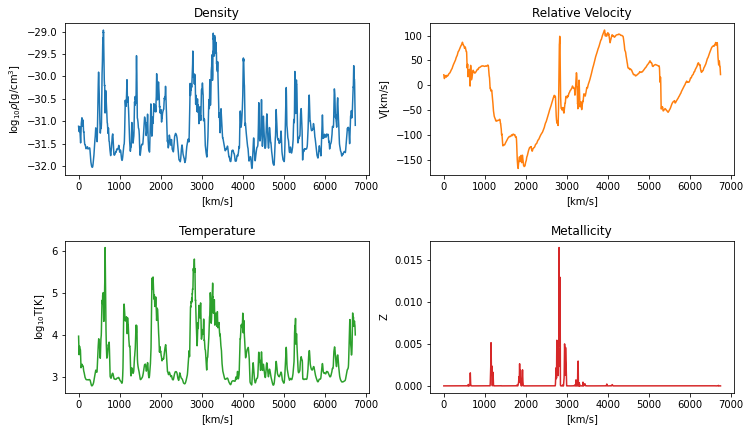

In [7]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
axs[0, 0].plot(np.log10(loss.rho_tot))
axs[0, 0].set_title('Density')
axs[0, 0].set_box_aspect(1/2)


axs[0, 1].plot(loss.veloc_tot, 'tab:orange')
axs[0, 1].set_title('Relative Velocity')
axs[0, 1].set_box_aspect(1/2)

axs[1, 0].plot(np.log10(loss.temp_tot), 'tab:green')
axs[1, 0].set_title('Temperature')
axs[1, 0].set_box_aspect(1/2)

axs[1, 1].plot(loss.met_tot, 'tab:red')
axs[1, 1].set_title('Metallicity')
axs[1, 1].set_box_aspect(1/2)

ylabels = [r"$\log_{10} \rho \mathrm{[g/cm^3]}$", "$\mathrm{V[km/s]}$","$\log_{10} \mathrm{T[K]}$","$\mathrm{Z}$"]
for i,ax in enumerate(axs.flat):
    ax.set(xlabel='[km/s]', ylabel=ylabels[i])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-0.5)